# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import numpy as np

import random
import torch
from collections import deque
import matplotlib.pyplot as plt
import time

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## 5. Utility function definitions

In [6]:
def log_game_state(steps, env_info, score, brain_name):
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    print('\rStep {}\tReward {}\tCumulative score {}\tIs Done {}'.format(steps, reward, score, done), end='')
    
    return

def extract_info(env_info):
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    
    return next_state, reward, done

# Variables for is_making_progress function, which is a kind of early stopping for the agent training
previous_score = 0
num_decreasing_score = 0
decreasing_score_threshold = 4

def is_making_progress(avg_score, threshold=0.001, target_score=13, decreasing_score_threshold=decreasing_score_threshold):
    global previous_score, num_decreasing_score
    
    score = avg_score
    
    if score < target_score:
        return True
    
    progress_made = (score - previous_score)/previous_score if previous_score != 0 else 1
    previous_score = score
    
    if progress_made < threshold:
        num_decreasing_score += 1
    
    print('\n\tScore improvement (%) : {:.3f} and threshold (%) : {:.3f}'.format(progress_made, threshold))
    
    return True if num_decreasing_score < decreasing_score_threshold else False

## 6. Create an instance of Agent

In [7]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

## 7. Use a dummy agent to play the game

In [8]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]
score, steps = 0, 0

# while True:
#     action = agent.act(state, eps=0.5)
#     env_info = env.step(action)[brain_name]
#     next_state = env_info.vector_observations[0]
#     reward = env_info.rewards[0]
#     done = env_info.local_done[0]
#     score += reward
#     steps += 1
#     state = next_state
#     log_game_state(steps, env_info, score, brain_name)
#     if done:
#         break

# print('\nScore from the untrained agent : {}'.format(score))

## 8. Train the agent using DQN

In [9]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_score=15):
    scores, avg_scores = [], []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        t0 = time.time()
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = extract_info(env_info)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        t1 = time.time() - t0

        scores_window.append(score)
        scores.append(score)
        avg_score = np.mean(scores_window)
        avg_scores.append(avg_score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f} in {:.2f} sec'.format(i_episode, avg_score, t1), end="")
    
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))

#         if np.mean(scores_window)>=target_score and not is_making_progress(avg_score, target_score):
        if np.mean(scores_window)>=target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tMin Score: {:.2f}'.format(i_episode-100, avg_score, np.min(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
            break
            
    return scores, avg_scores

In [10]:
%%time

scores, avg_scores = dqn(target_score=13)

Episode 100	Average Score: 0.65 in 0.73 sec
Episode 200	Average Score: 2.98 in 0.67 sec
Episode 300	Average Score: 6.11 in 0.73 sec
Episode 400	Average Score: 9.06 in 0.76 sec
Episode 500	Average Score: 11.39 in 0.72 sec
Episode 551	Average Score: 13.01 in 0.70 sec
Environment solved in 451 episodes!	Average Score: 13.01	Min Score: 2.00
CPU times: user 3min 9s, sys: 24.9 s, total: 3min 34s
Wall time: 6min 40s


## Plot the cumulative rewards history

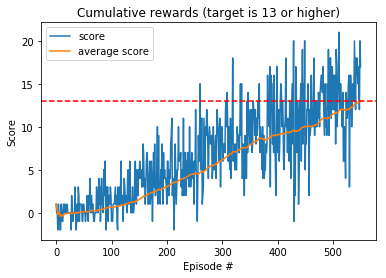

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='score')
plt.plot(np.arange(len(avg_scores)), avg_scores, label='average score')
plt.axhline(y=13, color='r', linestyle='--')
plt.legend(loc=2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Cumulative rewards (target is 13 or higher)')
plt.show()

## Evaluate the trained Agent

In [12]:
agent.qnetwork_local.load_state_dict(torch.load('model.pt'))

In [13]:
for i in range(10):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score, steps = 0, 0

    while True:
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state, reward, done = extract_info(env_info)
        score += reward
        steps += 1
        print('\rEpisode {}\tScore {:.2f} in {} steps'.format(i, score, steps), end="")
        if done:
            break
            
    print('\rEpisode {}\tScore {:.2f} in {} steps'.format(i, score, steps))

Episode 0	Score 20.00 in 300 steps
Episode 1	Score 9.00 in 300 steps
Episode 2	Score 11.00 in 300 steps
Episode 3	Score 4.00 in 300 steps
Episode 4	Score 4.00 in 300 steps
Episode 5	Score 9.00 in 300 steps
Episode 6	Score 0.00 in 300 steps
Episode 7	Score 2.00 in 300 steps
Episode 8	Score 8.00 in 300 steps
Episode 9	Score 13.00 in 300 steps


When finished, you can close the environment.

In [14]:
# env.close()